In [22]:
%matplotlib inline

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import astropy.stats as aps

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load data and make cuts.

In [2]:
gaia_mc0 = pd.read_csv("../code/gaia_mc5.csv")
print(len(gaia_mc0))

travis = pd.read_csv("Ruth_McQuillan_Masses_Out.csv")
masses = pd.DataFrame(dict({"kepid": travis.KIC.values, "Mass": travis.iso_mass.values}))
masses.head()
gaia_mc0 = pd.merge(masses, gaia_mc0, how="right", on="kepid", suffixes=["_berger", ""])

# Cut out photometric binaries.
m = gaia_mc0.flag.values == 1
gaia_mc1 = gaia_mc0.iloc[m]*1
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

plt.plot(gaia_mc0.bp_dered - gaia_mc0.rp_dered, gaia_mc0.abs_G, ".", alpha=.1)
plt.plot(gaia_mc1.bp_dered - gaia_mc1.rp_dered, gaia_mc1.abs_G, ".", alpha=.1)
plt.ylim(10, 1)
# gaia_mc1 = gaia_mc0

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 6000
# mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
# bmin = 10
# m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
m &= (gaia_mc1.b.values < bmax)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

# Remove velocity outliers
v_clipped, clipping_mask = sigma_clip(gaia_mc.vb.values, 3)
gaia_mc = gaia_mc.iloc[clipping_mask]

31357
(29462, 134) no large vb uncertainties
(29243, 134) no faint stars
(24608, 134) no rapid rotators
(20473, 134) no hot or cold stars
(14261, 134) no high latitude stars
niter =  7 237 stars removed kurtosis =  0.07657170953873038


For each point, calculate the velocity dispersion of the nearest 50 points.

In [7]:
# Calculate tangential distance.
def tan_dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def test_tan_dist():
    x1, y1 = 1, 1
    x2, y2 = 2, 2
    assert tan_dist(x1, y1, x2, y2) == np.sqrt(2)

test_tan_dist()

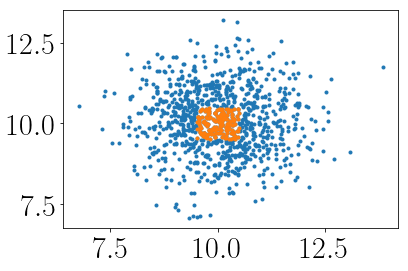

In [64]:
# Find N nearest points
def n_nearest_points(x1, y1, x2, y2, z2, N):
    td = tan_dist(x1, y1, x2, y2)
    inds = np.argsort(td)
    return x2[inds[:N]], y2[inds[:N]], z2[inds[:N]]

def test_n_nearest_points():
    x1, y1 = 10, 12
    np.random.seed(42)
    x2, y2 = [np.random.randn(1000) + 10 for i in range(2)]
    z2 = np.random.randn(1000)*y2
    nx, ny, nz = n_nearest_points(x1, y1, x2, y2, z2, 50)
    
#     plt.figure(figsize=(4, 4), dpi=200)
#     plt.plot(x2, y2, ".", ms=3)
#     plt.plot(nx, ny, ".", ms=3)
#     plt.plot(x1, y1, "o", ms=3)

test_n_nearest_points()

def make_bin(x1, y1, x2, y2, z2, xrange, yrange):
    dx, dy = xrange/2., yrange/2.
    xlower, xupper = x1 - dx, x1 + dx
    ylower, yupper = y1 - dy, y1 + dy
    
    m = (xlower < x2) * (x2 < xupper) * (ylower < y2) * (y2 < yupper)
    return x2[m], y2[m], z2[m]
 
def test_make_bin():
    np.random.seed(42)
    x, y, z = [np.random.randn(1000) + 10 for i in range(3)]
    bx, by, bz = make_bin(10, 10, x, y, z, 1, 1)
    plt.plot(x, y, ".")
    plt.plot(bx, by, ".")
    
test_make_bin()

In [66]:
# Calculate 1.5xMAD

# Run on each star
def calc_dispersion_nearest(x, y, z, N):
    
    dispersions = np.zeros(len(x))
    for i in trange(len(x)):
        nx, ny, nz = n_nearest_points(x[i], y[i], x, y, z, N)
        dispersions[i] = 1.5*aps.median_absolute_deviation(nz, ignore_nan=True)
    
    return dispersions

# Run on each star
def calc_dispersion_bins(x, y, z, xrange, yrange):
    
    dispersions = np.zeros(len(x))
    for i in trange(len(x)):
        nx, ny, nz = make_bin(x[i], y[i], x, y, z, xrange, yrange)
        dispersions[i] = 1.5*aps.median_absolute_deviation(nz, ignore_nan=True)
    
    return dispersions

def test_calc_dispersion():
    x2, y2 = [np.random.randn(10000) + 10 for i in range(2)]
    z2 = np.random.randn(10000)*y2
    
    dispersions_nearest = calc_dispersion_nearest(x2, y2, z2, 1000);
    dispersions_bins = calc_dispersion_bins(x2, y2, z2, .5, .5);
    
    return dispersions_nearest, dispersions_bins

dispersions_nearest, dispersions_bins = test_calc_dispersion()

100%|██████████| 10000/10000 [00:01<00:00, 7195.53it/s]


In [69]:
x2, y2 = [np.random.randn(10000) + 10 for i in range(2)]
z2 = np.random.randn(10000)*y2

In [116]:
dispersions_nearest = calc_dispersion_nearest(x2, y2, z2, 500);

100%|██████████| 10000/10000 [00:07<00:00, 1359.61it/s]


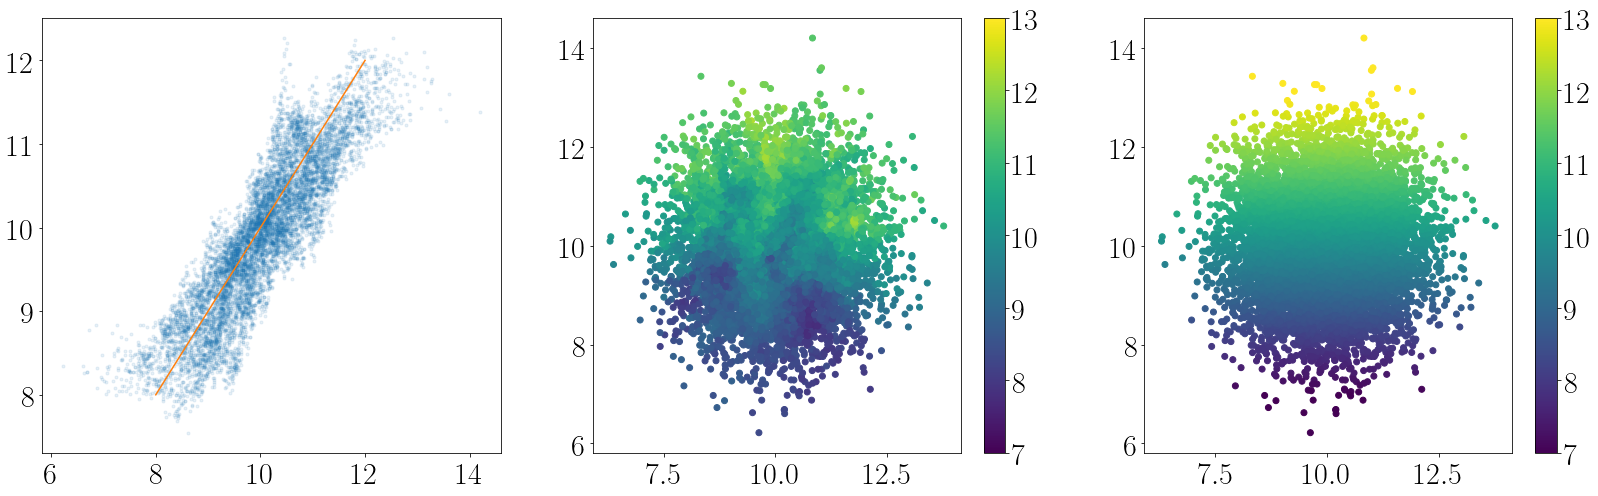

In [117]:
plt.figure(figsize=(28, 8))
    
plt.subplot(1, 3, 1)
plt.plot(y2, dispersions_nearest, ".", alpha=.1);
xs = np.linspace(8, 12, 100)
plt.plot(xs, xs)
    
plt.subplot(1, 3, 2)
plt.scatter(x2, y2, c=dispersions_nearest, vmax=13, vmin=7);
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x2, y2, c=y2, vmax=13, vmin=7);
plt.colorbar()

In [102]:
dispersions_bins = calc_dispersion_bins(x2, y2, z2, 1.2, 1.2)

100%|██████████| 10000/10000 [00:02<00:00, 4821.52it/s]


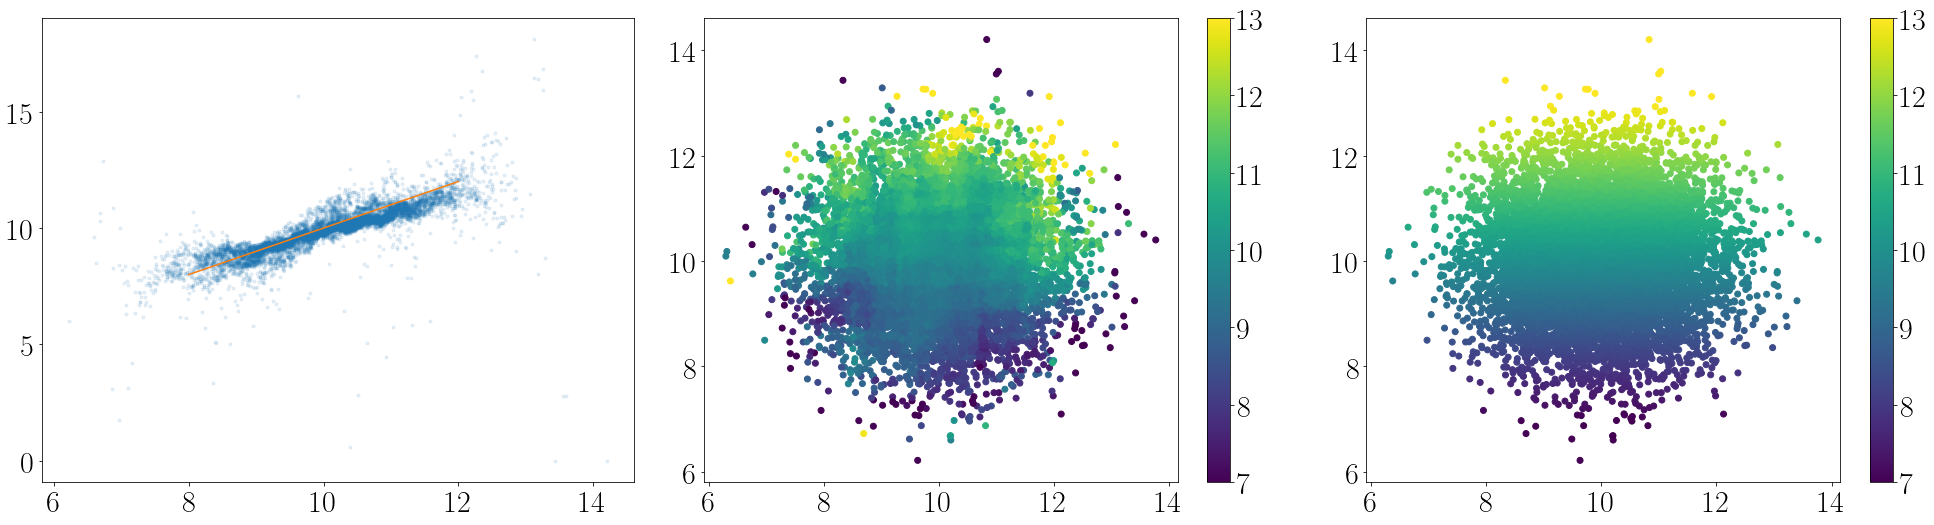

In [118]:
plt.figure(figsize=(28, 8))

plt.subplot(1, 3, 1)
plt.plot(y2, dispersions_bins, ".", alpha=.1);
plt.plot(xs, xs)
    
plt.subplot(1, 3, 2)
plt.scatter(x2, y2, c=dispersions_bins, vmax=13, vmin=7);
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x2, y2, c=y2, vmax=13, vmin=7);
plt.colorbar()
    
plt.tight_layout()

In [168]:
def rescale(x):
    minx = min(x)
    _x = x - min(x)
    maxx = max(_x)
    return _x/max(_x), minx, maxx 

x, minteff, maxteff = rescale(gaia_mc.color_teffs.values)
y, minp, maxp = rescale(np.log10(gaia_mc.Prot.values))
z = gaia_mc.vb.values

In [164]:
dispersions_bins = calc_dispersion_bins(x, y, z, .12, .12)

100%|██████████| 14024/14024 [00:02<00:00, 5754.83it/s]


(6050, 3300)

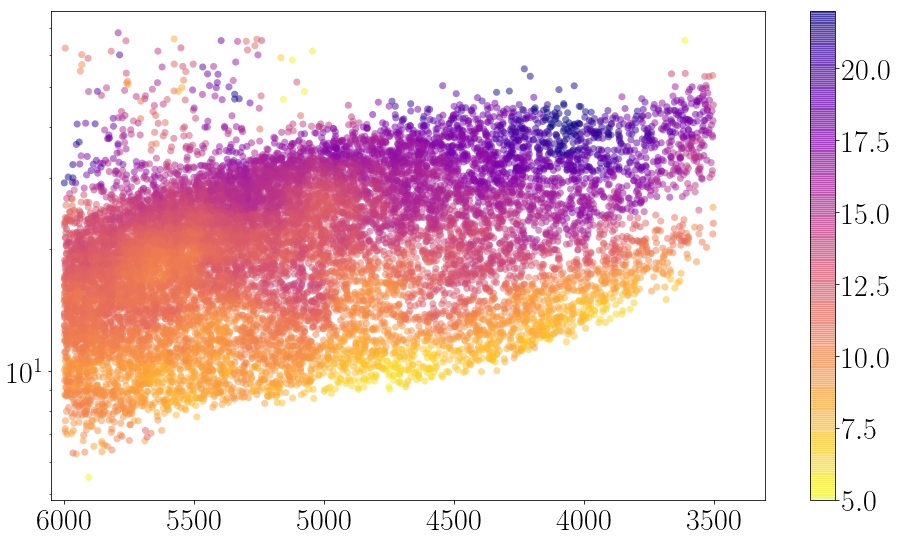

In [178]:
plt.figure(figsize=(16, 9))
teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp
plt.scatter(teff_scaled, 10**p_scaled, c=dispersions_bins, s=50, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)

In [166]:
dispersions_nearest = calc_dispersion_nearest(x, y, z, 300)

100%|██████████| 14024/14024 [00:13<00:00, 1052.80it/s]


(6050, 3300)

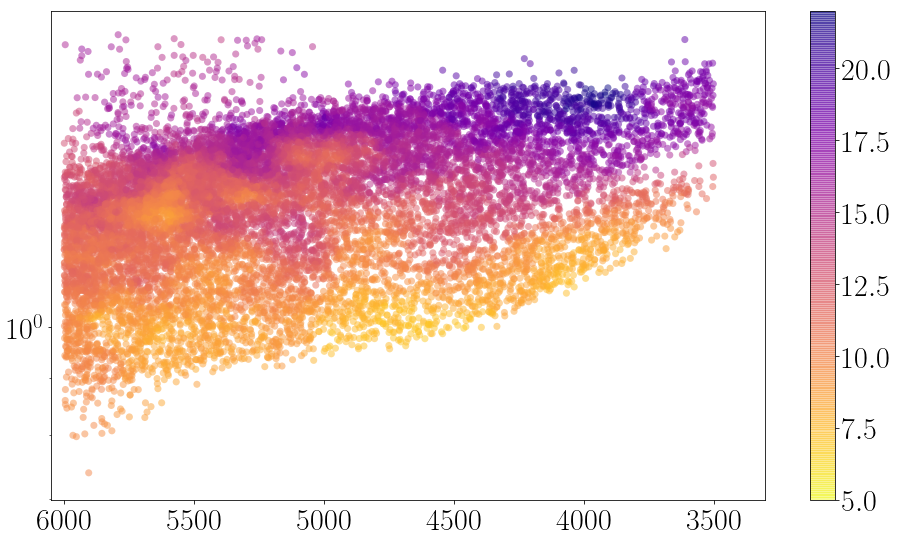

In [179]:
plt.figure(figsize=(16, 9))
teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp
plt.scatter(teff_scaled, p_scaled, c=dispersions_nearest, s=50, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)

(array([ 324.,  556.,  831., 1124., 1210., 1428., 1849., 2114., 2366.,
        2222.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

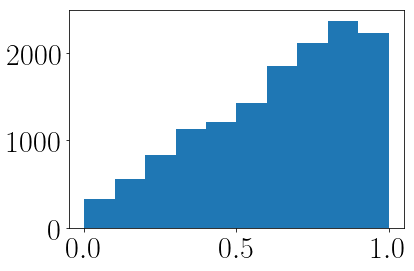